In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('fraudTrain.csv')
df_train.shape

(89474, 23)

In [3]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [4]:
df_train.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                 float64
job                       object
dob                       object
trans_num                 object
unix_time                float64
merch_lat                float64
merch_long               float64
is_fraud                 float64
dtype: object

Checking if any missing values present in the dataset

In [5]:
df_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 1
job                      1
dob                      1
trans_num                1
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64

Total genuine and fraud transactions

<Axes: >

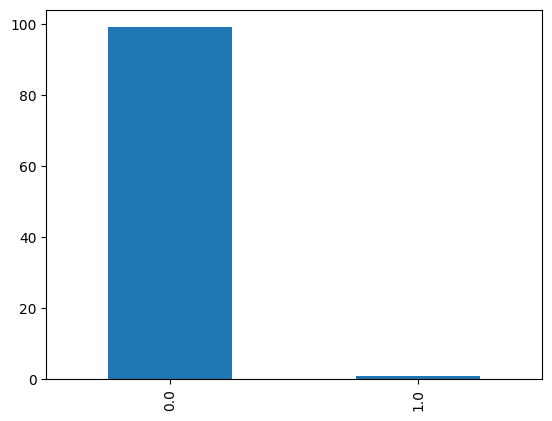

In [6]:
cnt =df_train['is_fraud'].value_counts()
prp = df_train['is_fraud'].value_counts(normalize =True)*100
t = pd.concat([cnt,prp],axis=1)
t.index=['Genuine','Fraud']
prp.plot(kind='bar')

Checking for duplicated records

In [7]:
df_train.duplicated().sum()

0

The columns like 'cc_num', 'first', 'last', 'trans_num' don't provide significant relevant information related to fraud detection. So, we drop it.

Dropping few columns

In [8]:
print(df_train.columns)
df_train.drop(['Unnamed: 0','first','last','trans_num','job'],axis = 1,inplace =True)
print(df_train.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


We convert the transaction date and time to separate columns which includes hour, day of a week and month

In [9]:
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])
df_train['Hour'] = df_train['trans_date_trans_time'].dt.hour
df_train['Day_of_week']= df_train['trans_date_trans_time'].dt.dayofweek
df_train['Month']=df_train['trans_date_trans_time'].dt.month

In [10]:
df_train['dob']=pd.to_datetime(df_train['dob'])
df_train['dob']

0       1988-03-09
1       1978-06-21
2       1962-01-19
3       1967-01-12
4       1986-03-28
           ...    
89469   1997-08-22
89470   1990-07-13
89471   1939-11-04
89472   1979-01-26
89473          NaT
Name: dob, Length: 89474, dtype: datetime64[ns]

# Mean amount in fraud and normal transactions

In [11]:
df_train.groupby('is_fraud')['amt'].mean()

is_fraud
0.0     67.314929
1.0    530.645813
Name: amt, dtype: float64

The mean amount for fradulent transaction was 531.32 whereas for normal transaction was relatively lower i.e 67.66

# Frequency of Transactions

In [12]:
def last1dayTransCnt(df_train):
    temp = pd.Series(df_train.index,index=df_train.trans_date_trans_time,name="In_a_Day").sort_index()
    #data (parameter) is df_train.index
    #temp is a series whose index is time stamp and value is row indices of corresponding time stamp
    In_a_Day = temp.rolling('1d').count()-1
#in a day is a series with timestamp as index and frequency as its value
    In_a_Day.index= temp.values
#in a day 's index is just 0 1 2; row indices of df_train or x
    df_train['In_a_Day'] = In_a_Day.reindex(df_train.index)
#df_train
    return df_train

In [13]:
def last1weekTransCnt(x):
    temp = pd.Series(x.index,index=x.trans_date_trans_time,name="In_a_Week").sort_index()
    In_a_Week = temp.rolling('7d').count()-1
    In_a_Week.index = temp.values
    x['In_a_Week'] = In_a_Week.reindex(x.index)
    return x

In [14]:
def last1monthTransCnt(x):
    temp = pd.Series(x.index,index=x.trans_date_trans_time,name="In_a_Month").sort_index()
    In_a_Month = temp.rolling('30d').count()-1
    In_a_Month.index = temp.values
    x['In_a_Month'] = In_a_Month.reindex(x.index)
    return x

In [15]:
df1d = df_train.groupby('cc_num').apply(last1dayTransCnt)
#drop = true ; we don't want to add new column
df1w = df1d.reset_index(drop=True).groupby('cc_num').apply(last1weekTransCnt)
df1dm = df1w.reset_index(drop=True).groupby('cc_num').apply(last1monthTransCnt)
df1dm

<ipython-input-15-8200877336ad>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df1d = df_train.groupby('cc_num').apply(last1dayTransCnt)
<ipython-input-15-8200877336ad>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df1w = df1d.reset_index(drop=True).groupby('cc_num').apply(last1weekTransCnt

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,unix_time,merch_lat,merch_long,is_fraud,Hour,Day_of_week,Month,In_a_Day,In_a_Week,In_a_Month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,...,1.325376e+09,36.011293,-82.048315,0.0,0,1,1,0.0,0.0,0.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,...,1.325376e+09,49.159047,-118.186462,0.0,0,1,1,0.0,0.0,0.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,...,1.325376e+09,43.150704,-112.154481,0.0,0,1,1,0.0,0.0,0.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,...,1.325376e+09,47.034331,-112.561071,0.0,0,1,1,0.0,0.0,0.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,...,1.325376e+09,38.674999,-78.632459,0.0,0,1,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89469,2019-02-22 16:48:37,2720433095629877,"fraud_Turner, Ziemann and Lehner",food_dining,9.45,M,854 Walker Dale Suite 488,Bowdoin,ME,4287,...,1.329929e+09,44.609033,-70.900814,0.0,16,4,2,2.0,31.0,109.0
89470,2019-02-22 16:50:53,4642894980163,"fraud_Dare, Fritsch and Zboncak",health_fitness,3.50,M,1831 Faith View Suite 653,Clarinda,IA,51632,...,1.329929e+09,40.025783,-95.675201,0.0,16,4,2,3.0,17.0,89.0
89471,2019-02-22 16:50:58,4430881574719618,fraud_O'Hara-Wilderman,food_dining,2.55,F,4456 Dunn Roads,Meredith,CO,81642,...,1.329929e+09,39.643915,-106.147099,0.0,16,4,2,1.0,14.0,63.0
89472,2019-02-22 16:54:15,30518206766474,fraud_Jacobi and Sons,shopping_pos,2.63,F,471 Marquez Prairie Suite 680,Matthews,MO,63867,...,1.329930e+09,37.701132,-89.287019,0.0,16,4,2,4.0,18.0,64.0


# As per the frequency of transactions lets guess the fradulent transactions

Threshold for a certain transaction to be fraud estimated if no. of day, week or month is more that 90% of the data

In [16]:
threshold_day = df1dm['In_a_Day'].quantile(0.9)
threshold_week = df1dm['In_a_Week'].quantile(0.9)
threshold_month = df1dm['In_a_Month'].quantile(0.9)
df1dm['prolly_fraud'] = ((df1dm['In_a_Day']>threshold_day)|
                        (df1dm['In_a_Week']>threshold_week)|
                        (df1dm['In_a_Month']>threshold_month))
df1dm[(df1dm['prolly_fraud'] == True) & (df1dm['is_fraud'] == True)]

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,merch_lat,merch_long,is_fraud,Hour,Day_of_week,Month,In_a_Day,In_a_Week,In_a_Month,prolly_fraud
5577,2019-01-04 15:20:17,4922710831011201,fraud_Corwin-Gorczany,misc_net,795.22,F,6888 Hicks Stream Suite 954,Manor,PA,15665,...,40.352547,-79.327751,1.0,15,4,1,6.0,9.0,9.0,True
5612,2019-01-04 15:48:45,4922710831011201,"fraud_Bins, Balistreri and Beatty",shopping_pos,1015.80,F,6888 Hicks Stream Suite 954,Manor,PA,15665,...,40.306614,-79.961163,1.0,15,4,1,7.0,10.0,10.0,True
6110,2019-01-04 22:14:07,4922710831011201,fraud_Schmidt and Sons,shopping_net,898.81,F,6888 Hicks Stream Suite 954,Manor,PA,15665,...,41.126312,-80.513488,1.0,22,4,1,6.0,12.0,12.0,True
6121,2019-01-04 22:22:44,4922710831011201,fraud_Ankunding LLC,shopping_net,1001.63,F,6888 Hicks Stream Suite 954,Manor,PA,15665,...,39.911297,-80.626808,1.0,22,4,1,7.0,13.0,13.0,True
6223,2019-01-04 23:44:56,4922710831011201,fraud_Hills-Witting,shopping_net,1099.99,F,6888 Hicks Stream Suite 954,Manor,PA,15665,...,40.578351,-79.727578,1.0,23,4,1,7.0,14.0,14.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88556,2019-02-21 23:26:47,573860193545,fraud_Ullrich Ltd,kids_pets,21.51,M,0423 Kirby Field Suite 623,Wilmette,IL,60091,...,41.743470,-88.226643,1.0,23,3,2,6.0,26.0,105.0,True
88632,2019-02-22 01:01:40,573860193545,fraud_Hudson-Ratke,grocery_pos,349.92,M,0423 Kirby Field Suite 623,Wilmette,IL,60091,...,41.342204,-88.642469,1.0,1,4,2,6.0,27.0,106.0,True
88685,2019-02-22 02:19:55,573860193545,fraud_McDermott-Weimann,grocery_pos,304.75,M,0423 Kirby Field Suite 623,Wilmette,IL,60091,...,42.722479,-88.362364,1.0,2,4,2,7.0,28.0,106.0,True
88897,2019-02-22 06:48:21,6011504998544485,fraud_Botsford Ltd,shopping_pos,906.23,F,4038 Smith Avenue,Jones,AL,36749,...,31.581014,-85.874753,1.0,6,4,2,2.0,26.0,120.0,True


Merged this dataframe's columns to original one

In [17]:
"""df1dm has cc_num as index but we're trying to merge on basis of cc_num column as well
so we make cc_num a regular column before merging it"""
df1dm.reset_index(drop =True,inplace=True)
df_train = df_train.merge(df1dm[['trans_date_trans_time','prolly_fraud']], on = ['trans_date_trans_time'],how = 'left')
# df.drop(['prolly_fraud_x','prolly_fraud_y'], axis=1, inplace=True)
# df_train.head(3)

In [18]:
df_train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,Hour,Day_of_week,Month,prolly_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,...,3495.0,1988-03-09,1.325376e+09,36.011293,-82.048315,0.0,0,1,1,False
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,...,149.0,1978-06-21,1.325376e+09,49.159047,-118.186462,0.0,0,1,1,False
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,...,4154.0,1962-01-19,1.325376e+09,43.150704,-112.154481,0.0,0,1,1,False


# Correlation Heatmaps

Correlation heatmap of original data

<Axes: >

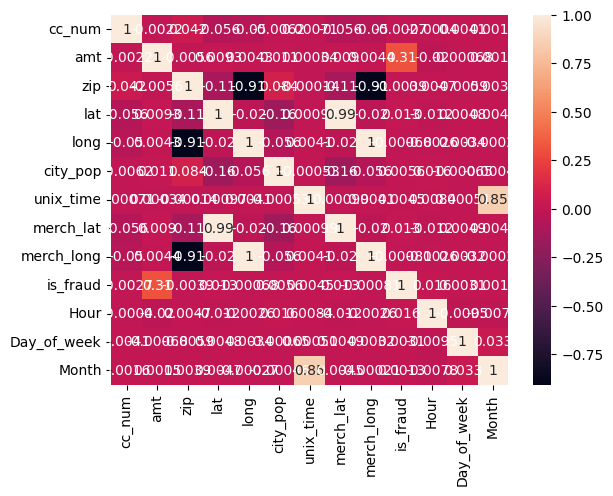

In [19]:
num_cols = df_train.select_dtypes(include = ['float64','int64'])
sns.heatmap(num_cols.corr(),annot = True)

Correlation heatmap of data with added features

<Axes: >

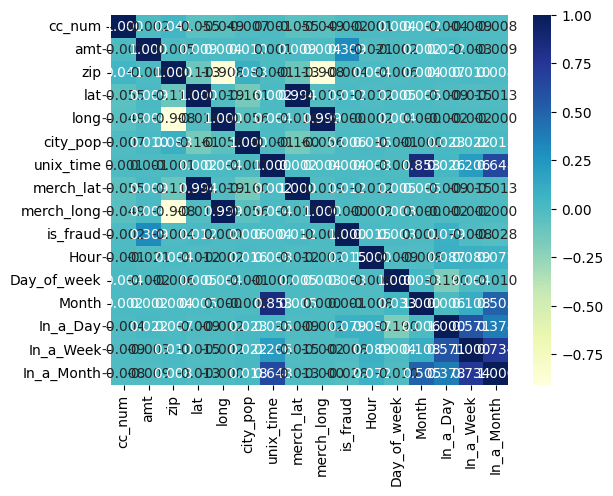

In [20]:
numeric_columns = df1dm.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True,fmt='.3f',cmap="YlGnBu")

# Frauds and Categories

In [21]:
cat_counts = df_train.groupby(['category','is_fraud'])['is_fraud'].count().unstack()
cat_counts

is_fraud,0.0,1.0
category,,
entertainment,6618,21
food_dining,6500,16
gas_transport,9186,71
grocery_net,3128,12
grocery_pos,8399,218
health_fitness,6163,15
home,8703,18
kids_pets,7817,33
misc_net,4417,109


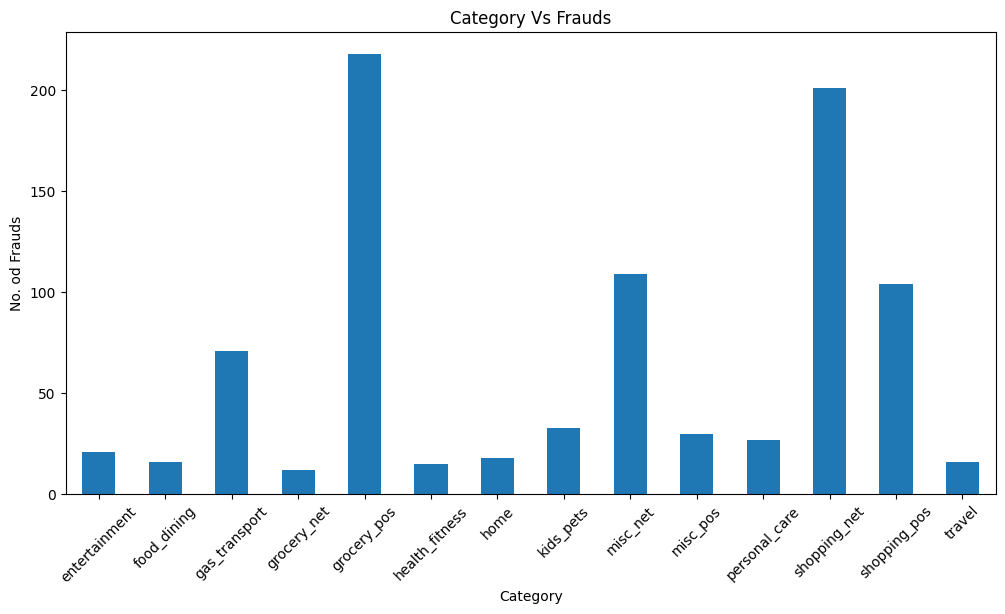

In [22]:
cat_counts_fraud = cat_counts[1]
ccc = cat_counts_fraud.plot(kind='bar', figsize=(12, 6))
ccc.set_ylabel('No. od Frauds')
ccc.set_xlabel('Category')
ccc.set_title('Category Vs Frauds')
plt.xticks(rotation=45)
plt.show()

Grocery and Shopping are the categories with the most frauds.

# Gender Wise Fraud

Text(0.5, 1.0, 'Bar Plot of is_fraud by Gender')

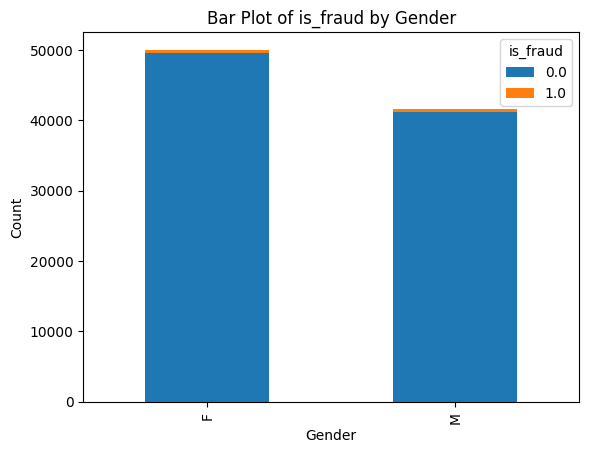

In [23]:
gen_counts = df_train.groupby(['gender','is_fraud'])['is_fraud'].count().unstack()
ax = gen_counts.plot(kind='bar', stacked=True)
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of is_fraud by Gender')

JUST A BIT DIFFERENT APPROACH

In [24]:
gen_counts = df_train[df_train['is_fraud'] == 1].groupby('gender')['is_fraud'].count()
gen_counts

gender
F    477
M    414
Name: is_fraud, dtype: int64

Text(0.5, 1.0, 'Gender Vs Fraud')

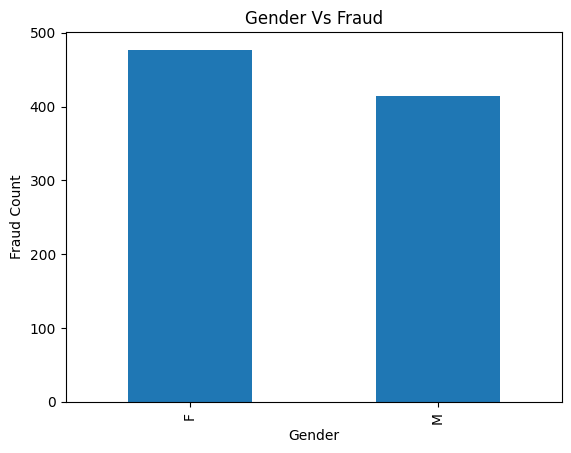

In [25]:
ax = gen_counts.plot(kind='bar')
ax.set_xlabel('Gender')
ax.set_ylabel('Fraud Count')
ax.set_title('Gender Vs Fraud')

This provides no significant information since both genders have experienced almost equal number of frauds

# Most common day of the week for fraud

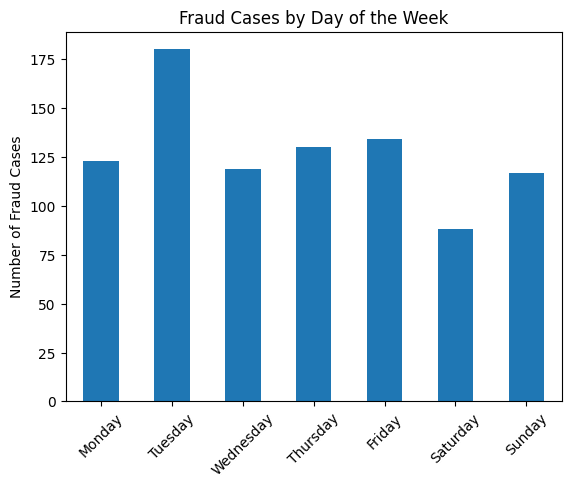

In [26]:
fraud_by_day = df_train[df_train['is_fraud']==1].groupby('Day_of_week')['is_fraud'].count()
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_day.index=(day_labels)
fraud_by_day.plot(kind='bar')
plt.ylabel('Number of Fraud Cases')
plt.title('Fraud Cases by Day of the Week')
plt.xticks(rotation = 45)
plt.show()

Most fraud transactions occur during the weekend. Saturday and Sunday

# Zip codes based fraud frequency

In [27]:
df_zip = df_train[df_train['is_fraud'] == 1].groupby('zip')['is_fraud'].count()
top_10_zip= df_zip.sort_values(ascending=False).head(10)
top_10_zip

zip
55606    20
99783    16
17051    16
97452    16
45150    16
4555     15
4047     15
11955    15
79063    14
62266    14
Name: is_fraud, dtype: int64

# City Vs Fraud

In [28]:
df_city = df_train[df_train['is_fraud'] == 1].groupby('city')['is_fraud'].count()
top_10_city= df_city.sort_values(ascending=False).head(10)
top_10_city

city
Warren          23
Hovland         20
Hampton         20
Milford         16
Mc Veytown      16
Lowell          16
Wales           16
Moriches        15
Parsonsfield    15
Nobleboro       15
Name: is_fraud, dtype: int64

Houston has the highest number of frauds occurence.

# Merchants Vs Fraud

In [29]:
df_mer = df_train[df_train['is_fraud'] == 1].groupby('merchant')['is_fraud'].count()
top_10_mer= df_mer.sort_values(ascending=False).head(10)
top_10_mer

merchant
fraud_Labadie, Treutel and Bode     9
fraud_Gleason-Macejkovic            9
fraud_Koepp-Witting                 9
fraud_Koepp-Parker                  9
fraud_Kilback LLC                   9
fraud_Towne, Greenholt and Koepp    8
fraud_Bauch-Raynor                  8
fraud_Kozey-Boehm                   7
fraud_Cole PLC                      7
fraud_O'Keefe-Hudson                7
Name: is_fraud, dtype: int64

# Dropping few more columns, encoding categorical columns and scaling the columns with numeric values

In [30]:
X = df_train.drop(['zip','lat','long','unix_time','merch_lat','merch_long', 'dob', 'trans_date_trans_time'],axis=1)
X= pd.get_dummies(X,columns=['merchant', 'category', 'gender', 'street', 'city', 'state'])

In [31]:
from sklearn.preprocessing import MinMaxScaler
num_colss= ['amt', 'city_pop', 'Hour', 'Day_of_week', 'Month']
scaler = MinMaxScaler()
X[num_colss] = scaler.fit_transform(X[num_colss])

In [32]:
y = X["is_fraud"]
X = X.drop("is_fraud",axis=1)

# Splitting into test and train data

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.4,random_state=40)

# Using Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [35]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

In [41]:
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score
X_test = X_test.dropna()
y_test=y_test.dropna()
print("Score of X-train with Y-train is : ", dtc.score(X_train,y_train))
print("Score of X-test  with Y-test  is : ", dtc.score(X_test,y_test))

y_pred=dtc.predict(X_test)

print("Accuracy score " , accuracy_score(y_test,y_pred))
print("F1 score: ", round(f1_score(y_test, y_pred, average='weighted')*100,2),"%")

Score of X-train with Y-train is :  1.0
Score of X-test  with Y-test  is :  0.9957144806878668
Accuracy score  0.9957144806878668
F1 score:  99.56 %


In [42]:
class_rep =classification_report(y_test,y_pred,labels=[1,0])

print('Classification report : \n',class_rep)

Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.71      0.77       359
           0       1.00      1.00      1.00     36276

    accuracy                           1.00     36635
   macro avg       0.91      0.86      0.88     36635
weighted avg       1.00      1.00      1.00     36635



83% of predicted frauds are actual frauds.
71% of actual frauds were correctly classified as frauds.